# Per Component Model A

## Data Prep

### Loading and Building Signal

In [12]:
%cd ../..
from src.data.files import Data
from src.data.synthesizer import ModelASignal, MachineSignalSynth

import pandas as pd
from sklearn.model_selection import train_test_split

all_events = Data.get_events()
tel = Data.get_telemetry()
synthesizer = MachineSignalSynth(tel, all_events, ModelASignal(["comp1"]))
raw_signal = synthesizer.generate()

/


In [13]:
ANOMALY = "anomaly"
MODEL = "model"

raw_signal[ANOMALY] = raw_signal[ANOMALY].astype(int)
raw_signal[MODEL] = raw_signal[MODEL].astype('category')
raw_signal[MODEL] = raw_signal[MODEL].cat.codes

In [17]:
raw_signal = raw_signal.sort_values(by="datetime")# loc[raw_signal["datetime"] == "2015-01-01 06:00:00"]
raw_signal

,datetime,machineID,volt,rotate,pressure,vibration,model,age,anomaly,fail_window_comp1
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686,2,18,0,0
455572,2015-01-01 06:00:00,53,183.084582,420.980061,109.235805,45.737760,2,5,0,0
858578,2015-01-01 06:00:00,99,168.596133,384.747105,110.921131,41.944692,0,14,0,0
96371,2015-01-01 06:00:00,12,171.404215,576.923563,97.145400,47.725909,2,9,0,0
43805,2015-01-01 06:00:00,6,136.878588,492.088420,149.003582,22.973289,2,7,0,0
...,...,...,...,...,...,...,...,...,...,...
613269,2016-01-01 06:00:00,70,188.135372,457.661580,89.725251,42.932201,2,9,0,0
622030,2016-01-01 06:00:00,71,174.028202,349.326013,111.231561,38.669674,1,18,0,0
630791,2016-01-01 06:00:00,72,183.176861,381.242172,104.658441,38.504998,3,2,0,0
648313,2016-01-01 06:00:00,74,188.299688,494.616310,101.785150,41.609665,3,4,0,0


In [13]:
y = raw_signal.loc[:, raw_signal.columns == LABEL]
X = raw_signal.loc[:, raw_signal.columns != LABEL]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) # , shuffle=False)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25) #, shuffle=False)

### Formatting for Sagemaker

In [14]:
train = pd.concat([y_train, X_train], axis=1)
validation = pd.concat([y_val, X_val], axis=1)
test = pd.concat([y_test, X_test], axis=1)

In [31]:
# Use 'csv' format to store the data
# The first column is expected to be the output column
train.to_csv('train.csv', index=False, header=False)
validation.to_csv('validation.csv', index=False, header=False)
test.to_csv('test.csv', index=False, header=False)

In [32]:
import sagemaker, boto3, os
bucket = "pmpf-data"
prefix = "sagemaker-xgboost-prediction"

boto3.Session().resource('s3').Bucket(bucket).Object(
    os.path.join(prefix, 'data/train.csv')).upload_file('train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(
    os.path.join(prefix, 'data/validation.csv')).upload_file('validation.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(
    os.path.join(prefix, 'data/test.csv')).upload_file('test.csv')

## Training Code

In [17]:
region = sagemaker.Session().boto_region_name
print("AWS Region: {}".format(region))
role = sagemaker.get_execution_role()
print("RoleArn: {}".format(role))

AWS Region: us-west-1
RoleArn: arn:aws:iam::328535504136:role/service-role/AmazonSageMaker-ExecutionRole-20230208T093579


In [18]:
from sagemaker.debugger import Rule, rule_configs
from sagemaker.session import TrainingInput

s3_output_location='s3://{}/{}/{}'.format(bucket, prefix, 'xgboost_model')

container=sagemaker.image_uris.retrieve("xgboost", region, "1.2-1")
print(container)

xgb_model=sagemaker.estimator.Estimator(
    image_uri=container,
    role=role,
    instance_count=1,
    instance_type='ml.m4.xlarge',
    volume_size=5,
    output_path=s3_output_location,
    sagemaker_session=sagemaker.Session(),
    rules=[Rule.sagemaker(rule_configs.create_xgboost_report())]
)
xgb_model.set_hyperparameters(
    max_depth = 4,
    eta = 0.2,
    gamma = 4,
    min_child_weight = 10,
    subsample = 0.7,
    objective = "binary:logistic",
    num_round = 500
)

746614075791.dkr.ecr.us-west-1.amazonaws.com/sagemaker-xgboost:1.2-1


In [19]:
from sagemaker.session import TrainingInput
train_input = TrainingInput(
    "s3://{}/{}/{}".format(bucket, prefix, "data/train.csv"), content_type="csv"
)
validation_input = TrainingInput(
    "s3://{}/{}/{}".format(bucket, prefix, "data/validation.csv"), content_type="csv"
)

#### Train It

In [20]:
xgb_model.fit({"train": train_input, "validation": validation_input}, wait=True)

2023-02-10 03:37:30 Starting - Starting the training job...
2023-02-10 03:38:00 Starting - Preparing the instances for trainingCreateXgboostReport: InProgress
ProfilerReport-1676000250: InProgress
.........
2023-02-10 03:39:20 Downloading - Downloading input data...
2023-02-10 03:40:00 Training - Downloading the training image...
2023-02-10 03:40:29 Training - Training image download completed. Training in progress....[2023-02-10 03:40:46.017 ip-10-0-120-45.us-west-1.compute.internal:8 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV 

#### Deploy It

In [30]:
from sagemaker.serializers import CSVSerializer
xgb_predictor=xgb_model.deploy(
    initial_instance_count=1,
    instance_type='ml.t2.medium',
    serializer=CSVSerializer()
)

--------!

In [13]:
xgb_predictor.endpoint_name

'sagemaker-xgboost-2023-02-09-06-09-56-353'

## Evaluation

In [23]:
import numpy as np
def predict(data, rows=1000):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, xgb_predictor.predict(array).decode('utf-8')])
    return np.fromstring(predictions[1:], sep=',')

In [24]:
import matplotlib.pyplot as plt

inputd = test.to_numpy()[:,1:]
inputd[:, 0] = 0
inputd[:, 6] = 0
inputd[:, 8] = 0
predictions=predict(inputd)
plt.hist(predictions)
plt.show()

ModelError: An error occurred (ModelError) when calling the InvokeEndpoint operation: Received client error (415) from primary with message "application/json is not an accepted ContentType: csv, libsvm, parquet, recordio-protobuf, text/csv, text/libsvm, text/x-libsvm, application/x-parquet, application/x-recordio-protobuf.". See https://us-west-1.console.aws.amazon.com/cloudwatch/home?region=us-west-1#logEventViewer:group=/aws/sagemaker/Endpoints/sagemaker-xgboost-2023-02-10-04-04-20-598 in account 328535504136 for more information.

In [32]:
import sklearn

cutoff=0.5
print(sklearn.metrics.confusion_matrix(test.iloc[:, 0], np.where(predictions > cutoff, 1, 0)))
print(sklearn.metrics.classification_report(test.iloc[:, 0], np.where(predictions > cutoff, 1, 0)))

[[153321   1249]
 [  7342  13308]]
              precision    recall  f1-score   support

           0       0.95      0.99      0.97    154570
           1       0.91      0.64      0.76     20650

    accuracy                           0.95    175220
   macro avg       0.93      0.82      0.86    175220
weighted avg       0.95      0.95      0.95    175220



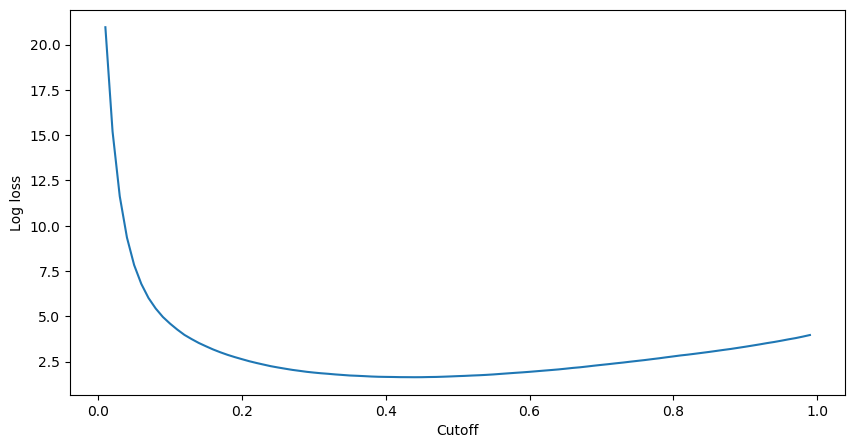

In [35]:
import matplotlib.pyplot as plt

cutoffs = np.arange(0.01, 1, 0.01)
log_loss = []
for c in cutoffs:
    log_loss.append(
        sklearn.metrics.log_loss(test.iloc[:, 0], np.where(predictions > c, 1, 0))
    )

plt.figure(figsize=(10,5))
plt.plot(cutoffs, log_loss)
plt.xlabel("Cutoff")
plt.ylabel("Log loss")
plt.show()

In [34]:
print(
    'Log loss is minimized at a cutoff of ', cutoffs[np.argmin(log_loss)], 
    ', and the log loss value at the minimum is ', np.min(log_loss)
)

Log loss is minimized at a cutoff of  0.44 , and the log loss value at the minimum is  1.6333173177903146


In [21]:
test.head(20)

,fail_window,datetime,machineID,volt,rotate,pressure,vibration,model,age,anomaly,std_volt,mean_volt,std_rotate,mean_rotate,std_vibration,mean_vibration,std_pressure,mean_pressure
6891,1,2015-10-15 09:00:00,1,167.361711,335.565398,103.112850,32.692940,2,18,0,14.585750,169.711371,50.425905,445.815560,4.916486,40.190956,11.261719,101.016448
656292,0,2015-11-29 16:00:00,75,166.761977,516.305738,103.141871,42.355818,2,19,0,15.039081,171.186968,58.125505,454.894049,5.684428,40.876524,15.316940,112.513057
616973,0,2015-06-04 13:00:00,71,179.871368,399.949090,91.923690,28.553383,1,18,0,14.120177,168.018794,50.903990,438.438087,5.100016,40.615715,10.482492,97.994143
381216,0,2015-07-07 11:00:00,44,182.337946,470.786624,101.513398,45.458076,3,7,0,15.361573,170.115995,49.442818,445.649831,7.523737,44.055512,10.502834,100.915701
63838,0,2015-04-15 21:00:00,8,206.907459,365.906653,82.333418,44.322127,2,16,0,15.423573,172.141141,63.979271,430.316613,4.480288,39.443845,9.040782,98.511310
157290,0,2015-12-15 07:00:00,18,151.781814,421.192236,103.111406,39.158423,2,15,0,15.582861,170.163895,60.342325,415.141736,4.567217,39.556834,9.824723,98.911310
188584,0,2015-07-12 01:00:00,22,160.532266,393.676720,113.817020,41.043155,0,14,0,13.786742,169.448051,49.753095,458.933819,5.120608,40.018431,9.052107,100.652647
553576,0,2015-03-10 07:00:00,64,167.392238,326.886718,102.993213,40.143798,2,20,0,16.832216,172.523186,51.534545,451.070284,4.669523,40.133981,9.447646,99.710751
20926,0,2015-05-23 02:00:00,3,177.019590,501.805407,108.477730,40.101672,2,8,0,15.057429,169.662485,62.253281,408.566312,5.106123,40.123170,11.482742,100.671442
469901,0,2015-08-21 06:00:00,54,175.642541,460.214802,77.951403,41.545371,1,10,0,15.119328,169.642699,41.418393,457.028424,4.565388,40.084044,10.092815,100.533575


In [40]:
predictions=predict(inputd[:20])
print(predictions)

[0.01656838 0.00215282 0.2324357  0.02219372 0.01384743 0.10336875
 0.2026487  0.21061452 0.00435823 0.02516961 0.0575682  0.02390198
 0.01143255 0.00738803 0.05368387 0.68556291 0.22499888 0.01922979
 0.16705067 0.05245109]


In [25]:
body = {
    "instances":    [
        {
            "features": list(inputd[0])
        }
    ]
}

In [ ]:
# Serializing json  
json_object = json.dumps(dictionary, indent = 4) 
print(json_object)

{
    "instances": [
        {
            "features": [
                0,
                1,
                167.361711134525,
                335.565398404129,
                103.112849652338,
                32.6929400534502,
                0,
                18,
                0,
                14.585750224724798,
                169.71137100014445,
                50.42590451036694,
                445.81556035837826,
                4.9164856247484,
                40.19095627910928,
                11.261718943111553,
                101.01644791612262
            ]
        }
    ]
}


In [44]:
test_df = pd.read_csv("s3://pmpf-data/sagemaker-xgboost-prediction/data/test.csv", header=None)

In [60]:
test_df.iloc[[4]].values.flatten().tolist()

[0,
 '2015-04-15 21:00:00',
 8,
 206.90745931761,
 365.906652649601,
 82.3334184313073,
 44.3221267828272,
 2,
 16,
 0,
 15.423573400301713,
 172.14114110151047,
 63.97927074096405,
 430.3166127053947,
 4.480287503984723,
 39.44384547915708,
 9.040781699434756,
 98.51130979933748]